In [28]:
#audio and video to npz file
import glob
import librosa
import numpy as np
import ffmpeg
import datetime as dt
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings


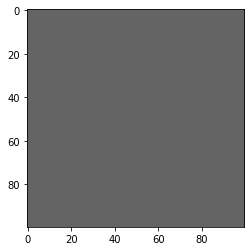

In [29]:
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

zero = np.full((100,100),100)
fig = plt.figure()
plt.imshow(zero,cmap='gray',vmin=0, vmax=255)
plt.show()

In [30]:
# npz[*] = [ [video audio] ] = [ [ 384 x 128 x 128 x 16] [ 105211 ] ] 

path = 'dataset/baum_acted/**/*.mp4'

#sample video from dataset
files = glob.glob(path)
print(len(files))
probe = ffmpeg.probe(files[0])
video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)
width = int(video_stream['width'])
height = int(video_stream['height'])

pre_time = dt.datetime.now()

audio_set = 84672

video_set = 115 #115

#******************************
#def find_excel(filename):

data = pd.read_excel('data/Annotations_BAUM1a.xlsx')

label_array = [1,2,3,4,5,6,7]


#*******************************

274


In [31]:
#audio function
def extract_audio(filename):
    audio, sample_rate = librosa.load(filename, res_type = 'kaiser_fast') #audio function
    fxn()
    size = audio.shape[0]
    
    odd = size%2
    
    if( size > audio_set ):
        offset = int((size - audio_set) / 2)
        start = offset
        end = size - offset - odd
        #print(size, start, end, end-start)
        audio = audio[start:end]
        
    if( size < audio_set ):
        offset = int((audio_set - size) / 2)
        start = np.zeros((offset))
        end = np.zeros((offset+odd))
        audio = np.concatenate((start,audio,end), axis=0)
    
    return audio

In [32]:
#video function
def extract_video(filename):
    out, _ = (
        ffmpeg
        .input(filename)
        .output('pipe:', format='rawvideo', pix_fmt='rgb24', loglevel='quiet')
        .run(capture_stdout=True)
    )
    #convert video to numpy array
    video = (
        np
        .frombuffer(out, np.uint8)
        .reshape([-1, height, width, 3])
    )
    size = video.shape[0]
    
    odd = not(size%2)
    
    if( size > video_set ):
        #print('more: ', size)
        offset = int((size - video_set) / 2)
        
        start = offset
        
        end = size - offset - odd
        
        #print(size, start, end, end-start)
        
        video = video[start:end]
        
    if( size < video_set ):
        #print('less: ', size)
        offset = int((video_set - size) / 2)
        #print('offset', offset)
        start = video[0]
        start = np.tile(start,(offset,1))
        start = start.reshape(offset, 480, 854, 3)
        
        end = video[size-1]
        end = np.tile(end,(offset + odd,1))
        end = end.reshape(offset + odd, 480, 854, 3)
        
        #print(start.shape)
        #print(video.shape)
        #print(end.shape)

        video = np.concatenate((start,video,end),axis=0)
    
    #print(video[0].shape)
    #new video array
    new = []
    
    for frame in video: # need to figure out size matching TODO
    #print( video[frame].shape )
        new_img = cv2.resize(frame, (128,128))#, interpolation=cv2.INTER_AREA)
        new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
        new.append(new_img)
    video = np.array(new)
    #print(video.shape[0])
    return video

In [37]:
def extract_all():
    video_files = []
    audio_files = []
    labels = []

    for filename in files:
        name = filename[24:32]
        #print(name)
        temp = data[data['Clip Name'] == name].index
        class_label = data['Emotion Code'][temp] #gets emotion given location of clip name
        class_label = pd.DataFrame(class_label).to_numpy()
        #print(name,temp,class_label.empty)
        if(class_label.size != 0 and (class_label in label_array)):
            class_label = class_label[0]# ugly solution but works to remove nested single element arrays
            class_label = class_label[0]
            #print(class_label)
            video = extract_video(filename)
            audio = extract_audio(filename)
            fxn()

            audio_files.append(audio)
            video_files.append(video)
            labels.append(label_array.index(class_label))
            #print(label_array.index(class_label))


            warnings.simplefilter("ignore")
            fxn()

            delta = dt.datetime.now()
            if( (int((delta - pre_time).seconds) % 60) == 0 ):
                print('audio size: ', audio.size )
                print('video size: ', video.size )
                print('label: ', class_label)
                plt.imshow(video[50],cmap='gray')
                plt.show()

    return (audio_files, video_files, labels)

audio size:  84672
video size:  1884160
label:  5


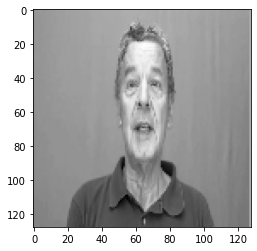

audio size:  84672
video size:  1884160
label:  5


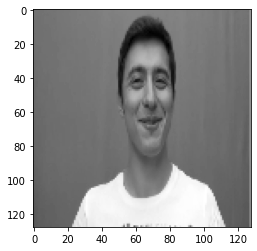

audio size:  84672
video size:  1884160
label:  2


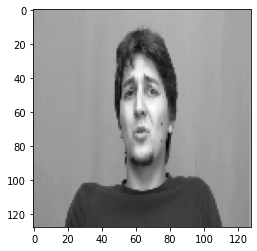

audio size:  84672
video size:  1884160
label:  3


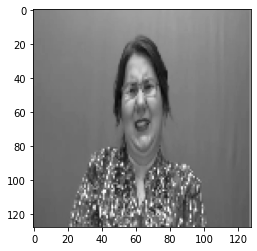

In [38]:
audio, video, labels = extract_all()
np.savez('data/BAUM_acted.npz', audio=audio, video=video, labels=labels)

In [ ]:
load = np.load('data/explore_audio.npz',allow_pickle=True)
audio = load['audio']
video = load['video']
labels = load['labels']
print(np.array(audio.shape))
plt.hist(audio,120)
plt.show()
median = np.median(audio)
print(median)
mean = np.mean(audio)
print(mean)

print('min', np.amin(audio))
print('max', np.amax(audio))

stdevs = np.std(audio)
plt.hist(stdevs)
plt.show()

idea #1
======


convert all sizes to mean, easier for arrays bigger, but filling in gaps until ratio reached
frames = video.shape[0] # number of frames
set_median = median
single_median = np.median(frames)
ratio = set_median / single_median



case ratio < 1
    #fill in gaps to reach
    new_array = []
    index = 0 
    while(index < single_median):
        index += ratio
        new_array.append(video[int(index)])
    new_array = new_array[:set_median]
    
    paulstretch
case ratio =>1
    samples from frames until ratio reached
    new_array = []
    index = 0
    while(index < single_median)
        index += ratio
        new_array.append(video[int(index)])
    new_array = new_array[:set_median]
        

idea #2 (from paper)
================
Since emotional video samples may have different duration, we split each of them into a certain number of overlapping segments and then learn audio-visual features from each segment. This also enlarges the amount of training data for our deep models.

(from paper)
To make sure each video segment has 16 frames, i.e., the input size in C3D-Sports-1M model [33], we delete the first and last (L−16)/2 overlapping frames if a video segment has L≥16 frames. On the contrary, for L<16 we repeat the first and last 16−L2 overlapping frames. It should be noted that, since we employ 64 audio frames in a context window to divide the extracted log Mel-spectrogram into audio segments, the durance of each segment is 655ms corresponding to about 20 video frames in each video segment, i.e., 0.655 s ×30 frame/s. In this case, our implementation does not need to deal with the case with L<16 frames. By contrast, when using 15 audio frames of Mel-spectrogram segments corresponding to about 5 video frames (L=5 ) for experiments, we need to repeat the first 5 and last 6 overlapping frames. We denote the visual input as v .


idea #3
========
Sample from video frames to achieve atleast 16 frames from video, minimal

if L<16
    fill with first and last reaches 16
    
if L>16
    sample every L/16
    until 16 frames achieved
    
median = 115

if L<115
    repeat first and last frames until reaches 115
if L>115
    remove first and last frames until reaches 115